# K-means from scratch

$$\newcommand{\vec}{\mathbf}\newcommand{\mat}{\mathbf}$$
* Cluster unlabeled data


In [1]:
using PyPlot

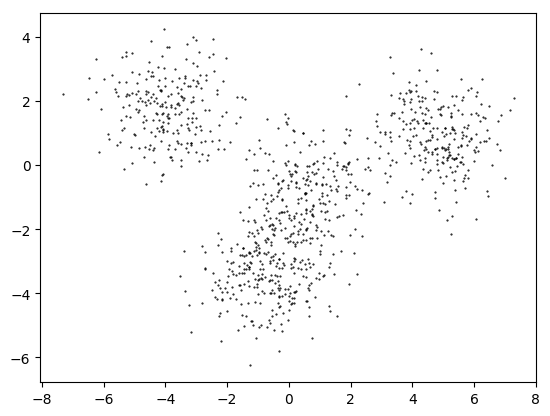

2×1000 Array{Float64,2}:
 -0.238954  -2.81391  5.79397   0.200144  …  0.143204  5.91416  5.53676 
 -4.96322    2.02804  1.2531   -2.92428      1.0862    1.59531  0.095083

In [2]:
# number of data points
N = 1000
# number of dimensins
n = 2
# generate random data
srand(1234)
x = randn(n,N)
nc = 4
xc_true = 3 * randn(n,nc)

for i = 1:N
    ic = rand(1:nc)
    x[:,i] = xc_true[:,ic] + randn(2)
end

plot(x[1,:],x[2,:],"k.",markersize = 1);
x

Let's try to find the centroid of the k clusters. Here k is 4 

In [3]:
k = 4

4

 Pick $k$ random elements of $x$ as initial centroids. This is the Forgy method for initialization.

In [4]:
xc = x[:,rand(1:N,k)]

2×4 Array{Float64,2}:
 1.55109   -1.45972   0.626195  -1.15342 
 0.107881  -3.70148  -3.82496   -0.554834

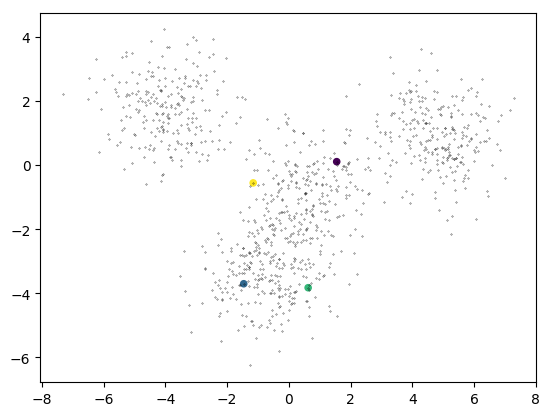

In [5]:
plot(x[1,:],x[2,:],"k.",markersize=0.5)
scatter(xc[1,:],xc[2,:],20,1:k);

We are just using the Euclidian distance here

In [6]:
distance(x,y) = sum((x-y).^2)

distance (generic function with 1 method)

To each data point $x_i$ (`x[:,i]`) assign the label correspond to the closest centroid.

In [7]:
label = zeros(Int,N)

function assignlabel!(x,xc,distance,label)
    N = size(x,2)
    k = size(xc,2)
    for i = 1:N
      mindist = 1e10
      for j = 1:k
        dist = distance(x[:,i],xc[:,j])
        if dist < mindist
           label[i] = j
           mindist = dist
        end
      end
    end
end
assignlabel!(x,xc,distance,label)

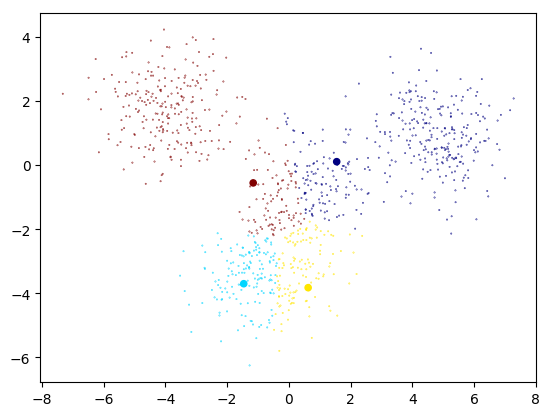

In [8]:
function plotcluster(x,label,xc)
    k = size(xc,2)
    scatter(xc[1,:],xc[2,:],20,1:k; cmap = "jet")
    scatter(x[1,:],x[2,:],0.1,label; cmap = "jet")
end
plotcluster(x,label,xc);

Update the centroids `xcnew` based on the labels

In [9]:
function updatemeans!(x,label,xcnew)
  k = size(xcnew,2)

  for j = 1:k;
    xcnew[:,j] = mean(x[:,label .== j],2)
  end
end

xcnew = similar(xc)
updatemeans!(x,label,xcnew)
xcnew

2×4 Array{Float64,2}:
 3.58948   -1.40562   0.438302  -2.90465
 0.476353  -3.49479  -3.29097    0.93377

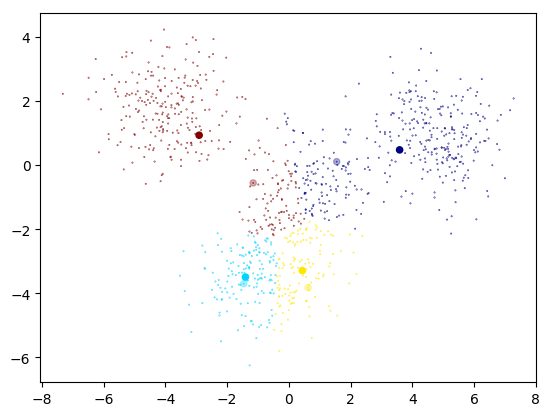

In [10]:
plotcluster(x,label,xcnew)
scatter(xc[1,:],xc[2,:],20,1:k; cmap = "jet", alpha = 0.3);

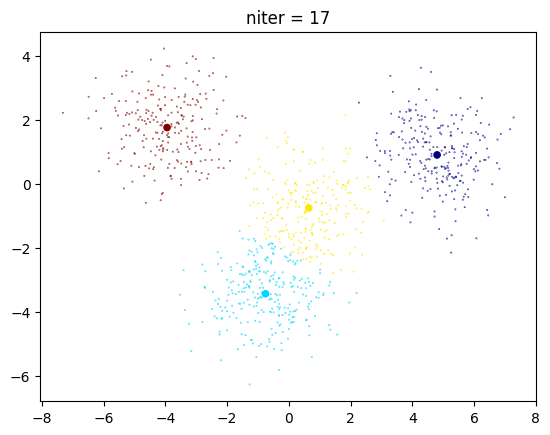

INFO: Converged


In [11]:
xc = x[:,rand(1:N,k)]
nmaxiter = 100
newlabel = zeros(Int,N)
fig = figure()
for niter = 1:nmaxiter
    assignlabel!(x,xc,distance,newlabel)
    updatemeans!(x,newlabel,xcnew)
 
    xc .= xcnew
    plotcluster(x,newlabel,xcnew)
    title("niter = $(niter)")
    sleep(1)
    IJulia.clear_output(true)
    display(fig)
    clf()
    
    if label == newlabel
        info("Converged")
        break
    end
    label .= newlabel     
end



Note how sometimes the algorithm does not converge

In [12]:
xc

2×4 Array{Float64,2}:
 4.80477   -0.754602   0.646769  -3.94462
 0.912755  -3.42157   -0.744018   1.76655

In [13]:
xc_true

2×4 Array{Float64,2}:
 -3.91166   0.526458  -0.789345  4.7484  
  1.76087  -0.828008  -3.40463   0.877456

Note the connection to the [Voroni diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)


# Gaussian mixture

In [14]:
n

2

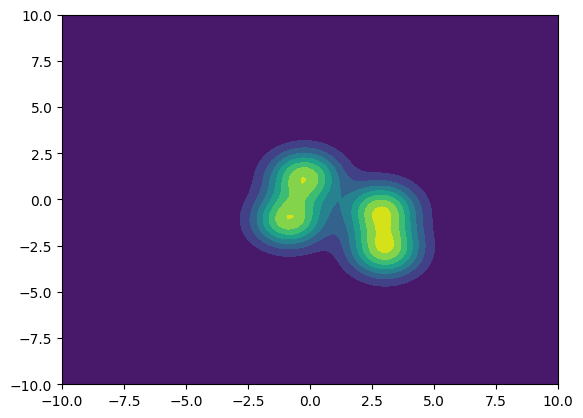

PyObject <matplotlib.contour.QuadContourSet object at 0x7f12b7327a10>

In [65]:
# initialize
k = 4
μ = 2*randn(n,k)
Σ = zeros(n,n,k);
Σ[1,1,:] = Σ[2,2,:] = 1
ϕ = ones(k)/k

Gaussian(x,μ,Σ) =  1/(sqrt(2π * det(Σ))) * exp(- (x - μ)' * (Σ \ (x - μ) )/2 )

function GMM(x,ϕ,μ,Σ)
    GMM = 0.
    for l = 1:size(μ,2)
        GMM += ϕ[l] * Gaussian(x,μ[:,l],Σ[:,:,l])
    end
    
    return GMM
end


gx = linspace(-10,10,100);
gy = linspace(-10,10,100);

p = zeros(length(gx),length(gy));
pk = zeros(length(gx),length(gy),k);

for j = 1:length(gy)
    for i = 1:length(gx)
        p[i,j] = GMM([gx[i]; gy[j]],μ,Σ);
        for l = 1:k
            pk[i,j,l] = Gaussian([gx[i]; gy[j]],μ[:,l],Σ[:,:,l]); 
        end
    end
end


contourf(gx,gy,p')

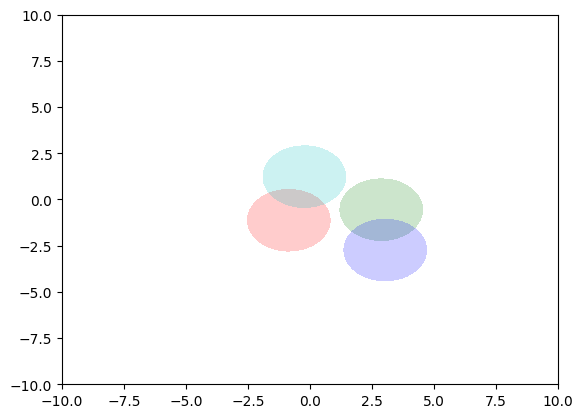

In [66]:
function plotGaussian(μ,Σ,color)
gx = linspace(-10,10,100);
gy = linspace(-10,10,100);

p = zeros(length(gx),length(gy));
#@show μ
for j = 1:length(gy)
    for i = 1:length(gx)
            p[i,j] = Gaussian([gx[i]; gy[j]],μ,Σ); 
        end
    end
    
contourf(gx,gy,p',levels = [0.1,100],colors=color,alpha=0.2)
            end
    
function plotGaussians(μ,Σ,colors = ["r","g","b","c"])
for l = 1:size(μ,2)
    plotGaussian(μ[:,l],Σ[:,:,l],colors[l])
end
end

plotGaussians(μ,Σ)

$$
P(\vec x_i \mid c) = \frac{1}{\sqrt{2\pi | \mat \Sigma_c | }} \exp\left(-\frac{1}{2}  (\vec x_i - \vec \mu_c)^T \Sigma_c^{-1} (\vec x_i - \vec \mu_c)  \right)
$$

Bayes rules

$$
P(c \mid \vec x_i) = \frac{P(\vec x_i \mid c) \; P(c) } {\sum_{c=1}^k P(\vec x_i \mid c) \; P(c) }
$$

$$
w_{i,c} = \frac{P(c \mid \vec x_i)}{\sum_{l=1}^{N} P(c \mid \vec x_l)}
$$

μ[:, l] = [NaN, NaN]
μ[:, l] = [NaN, NaN]
μ[:, l] = [NaN, NaN]
μ[:, l] = 

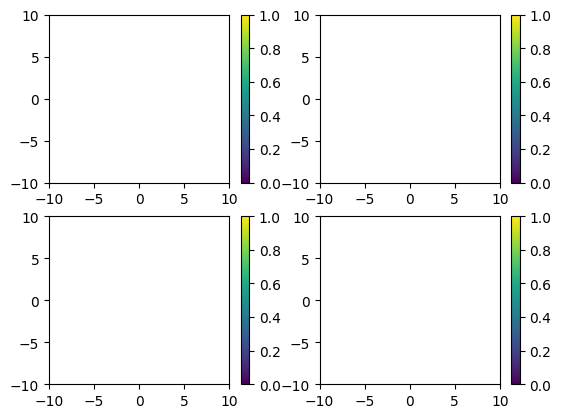

[NaN, NaN]


In [81]:

size(x)

function expectation_step(x,ϕ,μ,Σ)
P_x_given_c = zeros(k,N)

for i = 1:N
    for j = 1:k
        P_x_given_c[j,i] = Gaussian(x[:,i],μ[:,j],Σ[:,:,j]);
    end
end


P_c_given_x = zeros(k,N)
for i = 1:N
    for j = 1:k

       P_c_given_x[j,i] = P_x_given_c[j,i] * ϕ[j]
    end
    
    P_c_given_x[:,i] = P_c_given_x[:,i]/sum(P_c_given_x[:,i])
end

#w =  P_c_given_x ./ sum( P_c_given_x,2)
w =  P_c_given_x
return w,P_x_given_c
end
w,P_x_given_c = expectation_step(x,ϕ,μ,Σ) 

for l = 1:k
    subplot(2,2,l)

    #contour(gx,gy,pk[:,:,l]')
    plotGaussian(μ[:,l],Σ[:,:,l],"b")
    scatter(x[1,:],x[2,:],10,w[l,:]); colorbar();
    #scatter(x[1,:],x[2,:],10,P_x_given_c[1,:]); colorbar();
    @show μ[:,l]
end

In [52]:
w[1:3,:]'


1000×3 Array{Float64,2}:
 6.31273e-9   1.09312e-11  0.00684073 
 0.818814     0.175909     0.005277   
 0.000224183  0.175742     9.75254e-5 
 6.71043e-6   1.65329e-7   0.0392549  
 2.0065e-7    4.46251e-8   0.00113995 
 0.129886     0.0489849    0.565314   
 5.02492e-6   0.00228187   2.06465e-5 
 5.21678e-5   0.28414      9.62955e-6 
 1.14532e-5   0.00176258   7.29291e-5 
 0.00128732   0.992453     2.69092e-5 
 2.52012e-5   2.86639e-7   0.136884   
 0.969478     0.0264329    0.00408937 
 3.84736e-5   0.0105454    9.04383e-5 
 ⋮                                    
 0.000197811  1.05289e-6   0.548642   
 0.962248     0.00573165   0.0320202  
 0.00102875   0.597427     0.0002002  
 0.000157668  1.32805e-7   0.913309   
 3.04143e-7   2.14599e-8   0.00339061 
 0.967505     0.0267386    0.00575635 
 0.908635     0.0909804    0.000384329
 0.123877     0.0268343    0.684348   
 0.000484069  1.25991e-6   0.867604   
 0.342841     0.595873     0.0549811  
 0.000392472  0.504453     7.19186e-5 


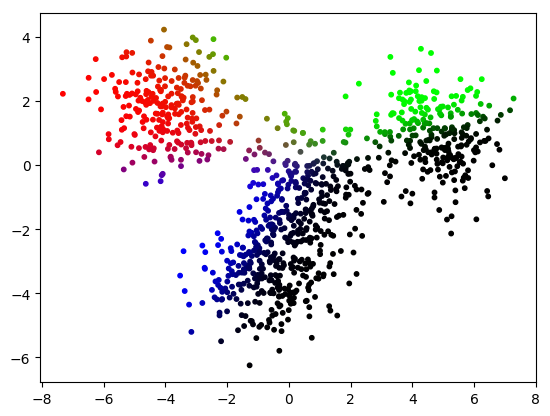

In [53]:
scatter(x[1,:],x[2,:],10,w[1:3,:]'/maximum(w)); 
#scatter(x[1,:],x[2,:],10,P_x_given_c[1:3,:]'/maximum(P_x_given_c)); 

In [82]:
function wmean(x,w)
    μ = zeros(size(x,1));
    for i = 1:size(x,2)
       μ += w[i] * x[:,i]
    end
    return μ / sum(w)
end
function wcovar(x,w; μ = wmean(x,w))
    Σ = zeros(length(μ),length(μ));
    for i = 1:size(x,2)
       Σ += w[i] * (x[:,i] - μ) * (x[:,i] - μ)'
    end
    return Σ / sum(w)
end
    

wcovar (generic function with 1 method)

In [55]:
wmean(x,w[1,:])

2-element Array{Float64,1}:
 -0.0120016
  0.0092514

In [56]:
μ[:,1]

2-element Array{Float64,1}:
 -1.89327
  1.50895

In [57]:
function maximization_step!(x,w,ϕ,μ,Σ)
   for j = 1:k
        ϕ[j] = sum(w[j,:])/size(w,2)        
        μ[:,j] = wmean(x,w[j,:])
        Σ[:,:,j] = wcovar(x,w[j,:])
    end
end

maximization_step! (generic function with 1 method)

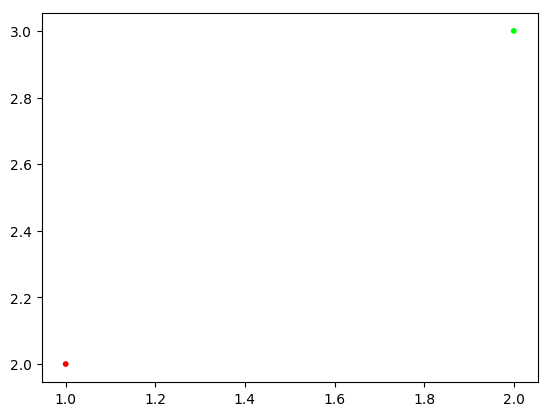

2×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0

In [58]:
scatter([1,2],[2,3],10,[1. 0 0; 0 1 0])
[1. 0 0; 0 1 0]

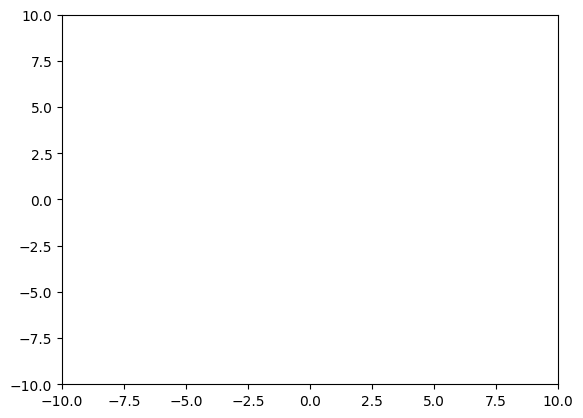

In [80]:
plotGaussians(μ,Σ)


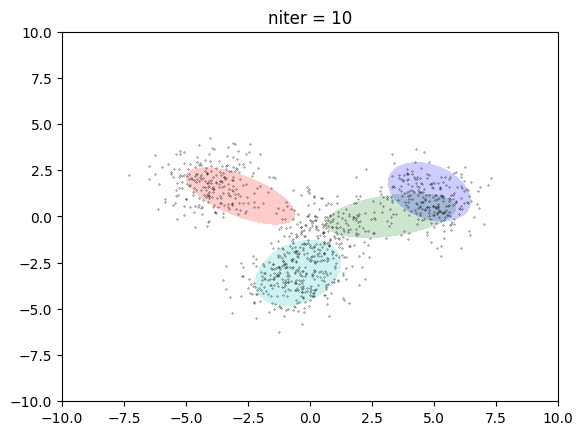

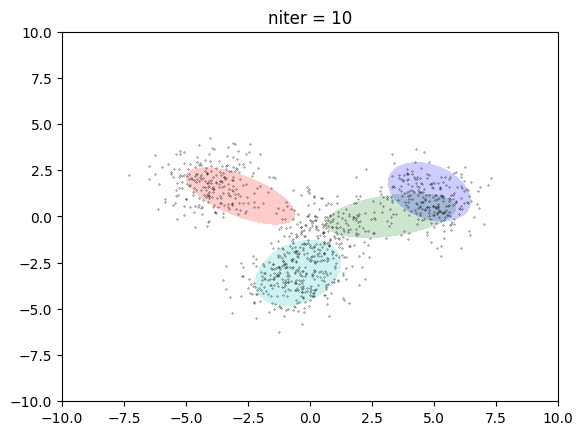

In [87]:
k = 4
μ = 2*randn(n,k)
Σ = zeros(n,n,k);
Σ[1,1,:] = Σ[2,2,:] = 1
ϕ = ones(k)/k

fig = figure()

for niter = 1:10
    w,P_x_given_c = expectation_step(x,ϕ,μ,Σ)  

    maximization_step!(x,w,ϕ,μ,Σ)
    #@show μ
    #scatter(x[1,:],x[2,:],10,w[1:3,:]'/maximum(w)); 
    
    if niter % 1 == 0
        clf()
        plot(x[1,:],x[2,:],"k.",markersize=0.5)
        plotGaussians(μ,Σ)
        sleep(1)
        title("niter = $(niter)")
        IJulia.clear_output(true)
        display(fig)
    end
end

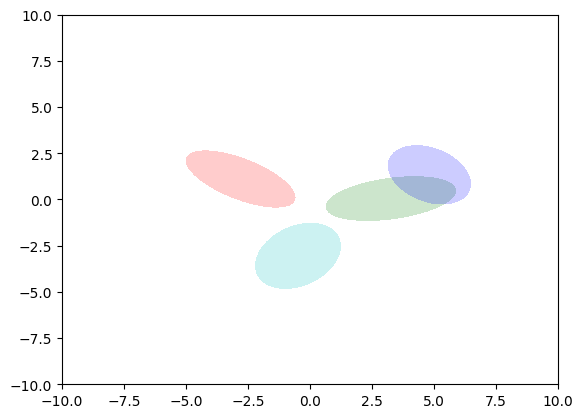

2×2×4 Array{Float64,3}:
[:, :, 1] =
  4.39483  -1.99586
 -1.99586   2.1151 

[:, :, 2] =
 4.16197   0.684634
 0.684634  0.847744

[:, :, 3] =
  0.802483  -0.240635
 -0.240635   0.727639

[:, :, 4] =
 1.18899   0.371015
 0.371015  1.26189 

In [88]:
plotGaussians(μ,Σ)
Σ